# Validation Test 0.0.0: Power Spectra of Simulated Noise Visibilities

Nick Kern and the HERA Validation Team
<br>
5/29/2019

## Table of Contents
1) [Simulating Noise Visibilities](#1.-Simulating-Noise-Visibilities)

2) [Forming Power Spectra](#2.-Forming-Power-Spectra)

3) [Comparing Noise Estimates](#3.-Comparing-Noise-Estimates)

4) [Summary](#4.-Summary)

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Setup and Metadata

### Abstract

This notebook aims to connect an estimate of the noise level from the visibities to the floor in the power spectrum $P(\tau)$ of those visibilities using code in `hera_pspec.noise`. For the purpose of this work, we assume noise to be a mean-zero, uncorrelated field that is drawn from a complex Gaussian distribution at the visibility (i.e. baseline) level, and is an additive term in the measurement equation.
This noise term need not be stationary as a function of time or frequency: in this notebook, we will adopt a frequency and time-dependent noise amplitude from simulated HERA visibilities.

In __Section 1__ we walkthrough the simulation of noise visibilities, in __Section 2__ we compute power spectra, and in __Section 3__ we compute analytic prediction of noise amplitude $P_N$ and bootstrap errorbars $\sigma_{\rm BS}$ and compare their amplitudes to the RMS of the calculated power spectra.

### Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import hera_pspec as hp
import hera_qm as hq
import hera_sim as hsim
import hera_stats as hs
import pyuvdata
from pyuvdata import UVData
import os
import glob
from hera_pspec.data import DATA_PATH
import copy
from datetime import datetime
import functools, operator
import healvis
from healvis import data as hvdata
import healpy
from scipy import interpolate, stats

In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

### Description

In [4]:
print("Last executed: %s"%str(datetime.now()))

Last executed: 2019-05-29 13:57:59.642730


- **Major Step Description:** Thermal noise and sky-locked Gaussian field validation
- **Minor Variation Description:** Simulate visibility thermal noise and compute power spectra
- **Code Tested:** `hera_pspec.pspecdata`, `hera_pspec.noise`, and `hera_pspec.grouping`
- **Criteria**:
  1. RMS of power spectra agree with $P_N$ calculation and bootstrapped errorbars to within finite sampling uncertainty  

### Summary

Both $P_N$ (`hera_pspec.noise`) and the bootstrapped errorbar $\sigma_{\rm BS}$ (`hera_pspec.grouping`) agree with the RMS of power spectra (`hera_pspec.pspecdata`) to within our finite sampling uncertainty.

### Software

In [5]:
for module in [pyuvdata, hs, hsim, hq, hp, np, healvis, healpy]:
    if hasattr(module, 'version'):
        gh = getattr(module.version, 'git_hash', None)
    print("Module {:<11}....\tVersion {:<7}.......\tGit {}".format(module.__name__, module.__version__, gh))

Module pyuvdata   ....	Version 1.3.8  .......	Git 680664d11c73f4afed6837c79aa7e4ff906242b4
Module hera_stats ....	Version 0.0.0  .......	Git 989aa29b785f80add514a70753622986e299fd90
Module hera_sim   ....	Version 0.0.1  .......	Git 7a08377e78575a6b41cad94f2d5d480b6f090fc2
Module hera_qm    ....	Version 1.0    .......	Git 2cd177f33f7d662cdf9d7be60175223d22cb8352
Module hera_pspec ....	Version 0.1.0  .......	Git 14755ec4282ad4312992d5f0b8a04f59d6dae03e
Module numpy      ....	Version 1.16.0 .......	Git None
Module healvis    ....	Version 1.0.0  .......	Git 7c10909ea4a3d7e85622b7da44698488e1bcbe97
Module healpy     ....	Version 1.12.8 .......	Git None


### Data

Most of the data for the notebook is generated on-the-fly as the notebook is evaluated.
The HERA simulation of the Global Sky Model (GSM; de Oliveira-Costa et al. 2008) can be found on NRAO lustre at
`/lustre/aoc/projects/hera/Validation/GSM_fullband/GSM_fullband_diam14.00_withautos.uvh5`, which was simulated with `healvis v1.0.0` (Lanman & Pober 2019), with skymodel `skymodels/gsm_100.00-199.90MHz_nside128.hdf5` and antenna beam parameters `{'beam_type': 'airy', 'fov': 180, 'diameter': 14.0}` (see file history for more details). In this notebook, I use a subset of that data that I extracted and pulled to my local machine, hence the different filename seen in this notebook.

## 1. Simulating Noise Visibilities

We start by simulating pure-noise visibilities. 

## 1.1 Formalism

To simulate noise for a complex, instrumental-polarization visibility (e.g. XX, YY, XY or YX) we first need to relate the system temperature to the RMS temperature of the visibilities. The system temperature is a combination of the receiver and sky temperature,

\begin{align}
\large
\label{eqn:Tsys}
T_{\rm sys} = T_{\rm sky} + T_{\rm rcvr},
\end{align}

where $T_{\rm sky}$ generally follows an inverse power law as a function of frequency, and is further dependent on the observing LST. The receiver temperature may also have a non-trivial frequency dependence, and may also have a slight dependence on local time due to ambient temperature fluctuations. In this notebook, we capture the LST and frequency dependence of $T_{\rm sky}$ via a simulated auto-correlation visibility (see below), and adopt a flat $T_{\rm rcvr} = 100$ K for all frequencies and times (DeBoer et al. 2017).

We can then relate the instantaneous system temperature to the RMS temperature of the noise in the visibilities via __the radiometer equation__, which states

\begin{align}
\label{eqn:Trms}
\large 
T_{\rm RMS} = \frac{T_{\rm sys}}{\sqrt{\Delta\nu\Delta t}},
\end{align}

where $\Delta\nu$ is the channel width in Hz and $\Delta t$ is the integration time in seconds.

The visibility has units of Jansky (or flux density) while temperature is a unit of specific intensity. We can relate the RMS temperature to the visibility RMS via

\begin{align}
\label{eqn:Vrms}
\large
V_{\rm RMS}(\nu)\ [\rm Jy] = T_{\rm RMS}(\nu)\ [\rm K] * \frac{2k_b\Omega_p(\nu)\nu^2}{c^2},
\end{align}

where $\Omega_P(\nu)$ is the sky-integral of the peak-normalized primary beam, and has units of steradians.


Let $V(t, \nu)$ represent the inteferometric visibility at time $t$ with an integration window of $\Delta t$ and at frequency $\nu$ with a channelization window of $\Delta \nu$. If the only component of the visibility is noise, then the distribution it is drawn from is

\begin{align}
\label{eqn:Vdist}
\large
V(t, \nu) \sim \langle\mathcal{N}(0, V_{\rm RMS}(t, \nu)/\sqrt{2}),\ i\mathcal{N}(0, V_{\rm RMS}(t, \nu)/\sqrt{2})\rangle,
\end{align}

where $\langle\rangle$ denote the real and imaginary component of the visibility, and the factor of $1/\sqrt{2}$ accounts for the fact that our system temperature specifies the RMS noise of the complex visibility amplitude, meaning that $1/\sqrt{2}$ of that noise is allocated into the real and imaginary components respectively.

__Note__: the above relations are operating under the assumption of visibilities in _instrumental polarization_, or linear dipole "auto" or "cross" polarization (e.g. XX, YY, XY or YX polarizations). Pseudo-Stokes (I, Q, U or V) viisbilities are formed by summing two of the instrumental polarization visibilities, and as such one should divide Equation \ref{eqn:Vrms} by an additional factor of $1/\sqrt{2}$ when calculating the noise on pseudo-Stokes visibilities.

## 1.2 Simulation

In order to compute an estimate of $V_{\rm RMS}$ for HERA, we use a simulated auto-correlation visibility from the Global Sky Model (GSM; de Oliveria-Costa 2008), which is essentially a frequency and time-dependent model of HERA antennas' $T_{\rm sys}$. We will populate all unique baselines of a HERA-50 array with noise of the same statistics but different realization.

In [6]:
# load data: load only a spectral window and only the auto-correlation in the data
auto = UVData()
auto.read("gsm_fullband_diam14.uvh5", freq_chans=np.arange(1024)[500:650], bls=[(0, 0)])

In [7]:
# make a new array that is larger
uvd = healvis.simulator.setup_uvdata(array_layout=healvis.data.DATA_PATH+'/configs/HERA65_layout.csv',
                                     telescope_location=auto.telescope_location_lat_lon_alt, telescope_name='HERA',
                                     freq_array=auto.freq_array[0], time_array=np.unique(auto.time_array),
                                     no_autos=False, pols=['xx'], make_full=False, redundancy=None)

# select out 100 unique baselines, in addition to a single auto-correlation
bls = [(0, 0)] + [bl for bl in uvd.get_antpairs() if bl[0] != bl[1]][:100]
uvd = healvis.simulator.setup_uvdata(array_layout=hvdata.DATA_PATH+'/configs/HERA65_layout.csv',
                                     telescope_location=auto.telescope_location_lat_lon_alt, telescope_name='HERA',
                                     freq_array=auto.freq_array[0], time_array=np.unique(auto.time_array),
                                     no_autos=False, pols=['xx'], make_full=True, bls=bls)

In [8]:
# fill in auto-correlation data
uvd.data_array[uvd.antpair2ind(0, 0), 0, :, 0] = auto.get_data(0, 0)

In [9]:
# get metadata
freqs = uvd.freq_array[0]
lsts = []
for l in uvd.lst_array:
    if l not in lsts: lsts.append(l)
lsts = np.unwrap(lsts)
if lsts[-1] > 2 * np.pi:
    lsts -= 2 * np.pi
lsts_hr = lsts * 12 / np.pi
times = np.unique(uvd.time_array)
integration_time = np.diff(times)[0] * 3600 * 24

# set integration time to proper amount
uvd.integration_time[:] = integration_time

### Get the beam
The simulation was performed with an airy disk model for the primary beam response (see __Data__ above). Here we will use `healvis.beam_model.AnalyticBeam` to compute the necessary beam integrals for simulating thermal noise in Jansky, and for power spectrum normalization. The first is $\Omega_{p}$, which is the sky integral of the primary beam power, and the second in $\Omega_{pp}$, which is the sky-integral of the squared primary beam power (Parsons et al. 2012a, Pober et al. 2013).

__Note__: this doesn't necessarily need to be done with `healvis`. One can also do this using a simulation of the HERA beam model (as found in `hera_pspec/data`) and loading it directly with `hera_pspec.PSpecBeamUV`. We use `healvis` just to be consistent with the beam model used to simulate the GSM foregrounds, but it actually isn't strictly necessary to use the same beam model in generating noise for the tests we do in this analysis.

In [10]:
# get beam
beam = healvis.beam_model.AnalyticBeam("airy", diameter=14.0)

# form zenith angle and azimuth arrays
nside = 64
npix = healpy.nside2npix(nside)
theta, phi = healpy.pix2ang(nside, np.arange(npix))

# evaluate beam at each point and perform discrete integral
pb = beam.beam_val(phi, theta, freqs)
dOmega = 4 * np.pi / npix
OmegaP = np.sum(pb, axis=0) *  dOmega
OmegaPP = np.sum(pb**2, axis=0) * dOmega

# form PSpecBeam
psbeam = hp.PSpecBeamFromArray({'xx': OmegaP}, {'xx': OmegaPP}, freqs)

In [11]:
# get auto-correlation in Kelvin (originally simulated into Jansky)
autocorr_Jy = np.abs(uvd.get_data(0, 0))
autocorr_K = autocorr_Jy * hsim.noise.jy2T(freqs/1e9, OmegaP) / 1e3 # output is mK, so 1e3 converts to

# assign Tsys
Trcvr = 100.0
Tsys = autocorr_K + Trcvr

Text(0,0.5,'$T_{\\rm sys}$ [K]')

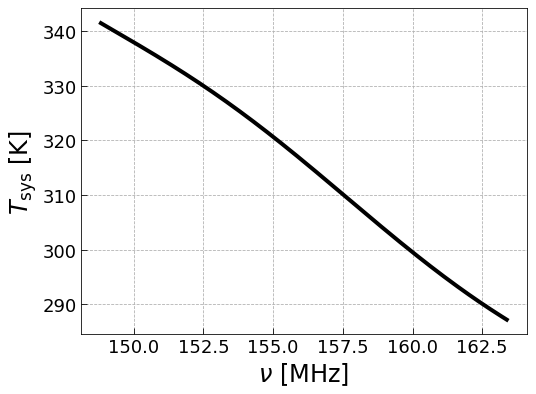

In [12]:
# plot time-averaged Tsys 
plt.figure(figsize=(8, 6))
plt.tick_params(labelsize=18, size=6, direction='in')
plt.plot(freqs/1e6, np.mean(Tsys, axis=0), color='k', lw=4)
plt.grid(ls='--')
plt.xlabel(r"$\nu$ [MHz]", fontsize=24)
plt.ylabel(r"$T_{\rm sys}$ [K]", fontsize=24)
#plt.ylim(250, 400)

__Figure 1__ | A time-averaged $T_{\rm sys}(\nu)$ for a HERA antenna.

In [13]:
# set seed
np.random.seed(0)

# iterate over baselines and populate with noise in Jansky
for bl in uvd.get_antpairs():
    if bl[0] == bl[1]: continue
    inds = uvd.antpair2ind(bl, ordered=False)
    uvd.data_array[inds, 0, :, 0] = hsim.noise.sky_noise_jy(Tsys, freqs/1e9, lsts, OmegaP, inttime=integration_time)

Text(0.5,1,'Cross Correlation Noise Realization')

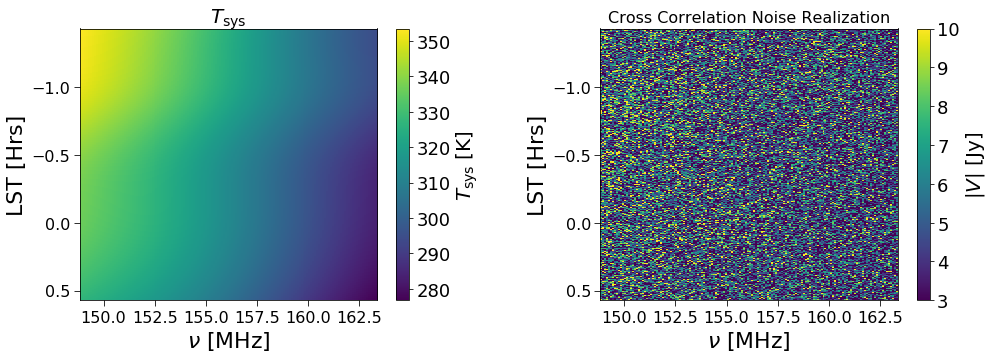

In [14]:
# plot thermal noise visibilities
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.subplots_adjust(wspace=0.4)

ax = axes[0]
cax = ax.imshow(Tsys, aspect='auto', vmin=None, vmax=None, cmap='viridis',
           extent=[freqs.min()/1e6, freqs.max()/1e6, lsts_hr.max(), lsts_hr.min()])
ax.tick_params(labelsize=16, size=6, direction='out')
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label(r"$T_{\rm sys}$ [K]", fontsize=20)
cbar.ax.tick_params(labelsize=18)
ax.set_xlabel(r"$\nu$ [MHz]", fontsize=22)
ax.set_ylabel(r"LST [Hrs]", fontsize=22)
ax.set_title(r"$T_{\rm sys}$", fontsize=20)

ax = axes[1]
cax = ax.imshow(np.abs(uvd.get_data(0, 1)), aspect='auto', vmin=3, vmax=10, cmap='viridis',
           extent=[freqs.min()/1e6, freqs.max()/1e6, lsts_hr.max(), lsts_hr.min()])
ax.tick_params(labelsize=16, size=6, direction='out')
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label(r"$|V|$ [Jy]", fontsize=20)
cbar.ax.tick_params(labelsize=18)
ax.set_xlabel(r"$\nu$ [MHz]", fontsize=22)
ax.set_ylabel(r"LST [Hrs]", fontsize=22)
ax.set_title("Cross Correlation Noise Realization", fontsize=16)

__Figure 2__ | Waterfall of $T_{\rm sys}$ (left) that will anchor the noise properties of our simulation, and a simulated noise visibility as a function of time and frequency (right).

## 2. Forming Power Spectra

Next we will use the machinery in `hera_pspec` to form power spectra from these noise visibilities. Furthermore, we will use `hera_pspec.noise` to calculate an estimate of $P_N$ given our understanding of the visibilities' system temperature, as well as `hera_pspec.grouping` to calculate the bootstrapped errorbars given the power spectra.

The power spectrum of the visibilities is defined as

\begin{align}
\label{eqn:dspec}
\large
P(k) \approx \left|\tilde{V}(\tau)\right|^2 \frac{X^2 Y}{\Omega_{\rm eff}B_{pp}}\left(\frac{\lambda^2}{2k_{B}}\right)^2\ [{\rm mK^2}\ h^{-3}\ {\rm Mpc^3}]
\end{align}

where $\tilde{V}$ is the visibility Fourier transformed into delay space ($\tau$), $X$ and $Y$ are scalars relating frequency and angle on the sky to cosmological distance in Mpc, $B_{pp}$ is the bandwidth of the frequency Fourier transform and $\Omega_{\rm eff}$ is an effective beam area equal to $\Omega_{\rm eff} = \Omega_{p}^2/\Omega_{pp}$ (Parsons et al. 2014).

## 2.1 Prep Data

In [15]:
# split into two interleaved UVData to avoid noise bias
# we don't need to rephase because there is no sky signal
uvd1 = uvd.select(times=times[0::2], inplace=False)
uvd2 = uvd.select(times=times[1::2], inplace=False)

In [16]:
# use default cosmology (Planck16) for scalar
cosmo = hp.conversions.Cosmo_Conversions()

# attach cosmology to beam
psbeam.cosmo = cosmo

## 2.2 Compute Power Spectra

In [17]:
# form pspecdata object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=psbeam)

In [18]:
# convert to mK
ds.Jy_to_mK()

In [19]:
# use blpairs that are baselines crossed with themselves
bls = [bl for bl in uvd.get_antpairs() if bl[0] != bl[1]]

In [20]:
# form power spectra within a spectral window
uvp = ds.pspec(bls, bls, (0, 1), [('xx', 'xx')], input_data_weight='identity', norm='I', taper='none',
               little_h=True, verbose=False, spw_ranges=[(50, 100)])

In [21]:
# get blpairs
blpairs = uvp.get_blpairs()
blpair_ints = [uvp.antnums_to_blpair(blp) for blp in blpairs]

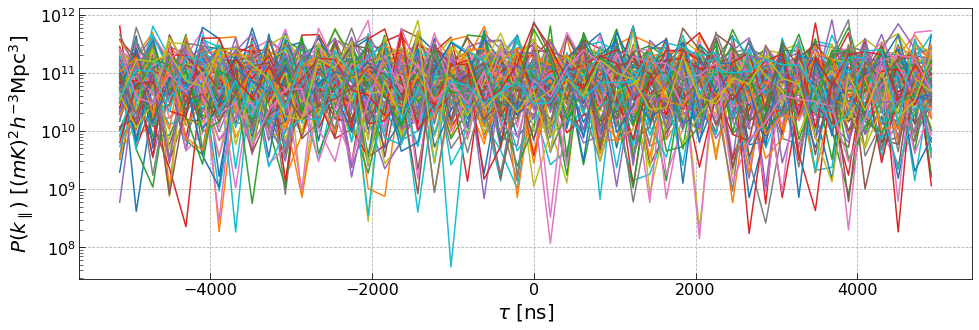

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

hp.plot.delay_spectrum(uvp.select(times=np.unique(uvp.time_avg_array)[:100], inplace=False),
                       blpairs[:1], 0, 'xx', force_plot=True, ax=ax, component='real')
ax.tick_params(labelsize=16, direction='in', size=6)
ax.tick_params(which='minor', direction='in', size=4)
ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_ylabel(ax.get_ylabel(), fontsize=20)
ax.grid(ls='--')

__Figure 3__ | Un-averaged power spectra of noise visibilities for a single baseline pair for ~100 time integrations.

## 3. Comparing Noise Estimates

In this section we compute noise estimates and compare them to the RMS of the power spectra without averaging across time or baseline-pair.

## 3.1 Analytic Noise Power

We can compute an analytic prediction of the noise power in the visibilities simply by taking Equation \ref{eqn:Vrms} and squaring it

\begin{align}
\label{eqn:PN}
\large
P_N = \frac{T_{\rm sys}^2X^2Y\Omega_{\rm eff}}{t_{\rm int}N_{\rm coherent}\sqrt{2N_{\rm incoherent}}}\ [{\rm mK^2}\ h^{-3}\ {\rm Mpc^3}],
\end{align}

where we can assume $T_{\rm sys}$ is in units of mK such that $P_N$ is proportional to mK$^2$, $t_{\rm int}$ is the correlator's integration time (equivalent to our $\Delta t$ before), and $N_{\rm coherent}$ represents the number of visibility averages performed __before squaring the data__, and $N_{\rm incoherent}$ represents the number of averages __after squaring the data__ (Parsons et al. 2012a, Pober et al. 2013, Cheng et al. 2018).
Note that this represents the __RMS noise power in the real component of the power spectra__ (hence the $1/\sqrt{2}$).

`hera_pspec.noise.calc_P_N` implements this equation, and `hera_pspec.uvpspec.UVPSpec.generate_noise_spectra` applies this for a specific set of power spectra at hand.

In [23]:
# calculate P_N for un-averaged pspectra
avg_Tsys = np.mean(Tsys[::2, 50:100], axis=1, keepdims=True)  # average Tsys in Kelvin from subband
print("Tsys : {:.2f} K".format(avg_Tsys.mean()))
P_N = uvp.generate_noise_spectra(0, 'xx', avg_Tsys, form='Pk')

Tsys : 316.01 K


In [25]:
# get RMS of real component of unaveraged power spectra
data = np.array([uvp.get_data((0, blp, 'xx')) for blp in uvp.get_blpairs()])
P_rms = np.sqrt(np.mean(np.abs(np.real(uvp.data_array[0]))**2))

In [26]:
print "P_N / P_rms = {:.5f}".format(np.mean(P_N[blpair_ints[0]] / P_rms))
print "with a sample tolerance of {:.2f}%".format(1/np.sqrt(uvp.Nblpairts*uvp.Ndlys)*100)

P_N / P_rms = 0.99937
with a sample tolerance of 0.08%


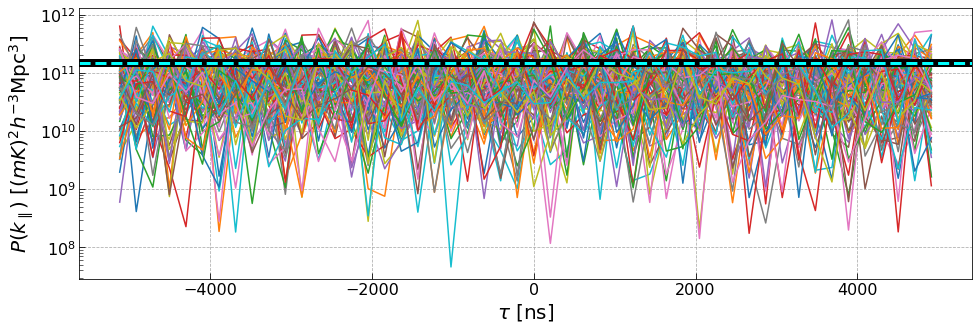

In [27]:
# plot it
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

hp.plot.delay_spectrum(uvp.select(times=np.unique(uvp.time_avg_array)[:100], inplace=False),
                       blpairs[:1], 0, 'xx', force_plot=True, ax=ax, component='real')
ax.tick_params(labelsize=16, direction='in', size=6)
ax.tick_params(which='minor', direction='in', size=4)
ax.axhline(P_rms, color='k', lw=8, ls='-')
ax.axhline(np.mean(P_N[blpair_ints[0]]), color='cyan', lw=3, ls='--')
ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_ylabel(ax.get_ylabel(), fontsize=20)
ax.grid(ls='--')

__Figure 4__ | Unaveraged power spectra with $P_N$ analytic prediction (blue dashed) and $P_{\rm RMS}$ (black solid), showing good agreement.

## 3.2 Bootstrapped Errorbars and Power Spectra Averaged Across baseline-pairs

Bootstrap resampling is a method for estimating the uncertainty of an operation by repeating the operation having resampled the inputs $N$ times with replacement, where $N$ is the number of inputs. `hera_pspec.grouping` contains methods for bootstrap resampling, and inserts the bootstrap errorbar into the averaged `UVPSpec` object as `bs_std`.

For this test, we will perform one uniform average of the power spectra across baseline-pairs (not time!) and also use bootstrap resampling to estimate the uncertainty on this average. We will additionally need to re-calculate the theoretical $P_N$ (because we have performed incoherent averaging), and also our estimate of $P_{\rm RMS}$.

In [28]:
# compute bootstrap group, and perofrm uniform average
Nsamples = 1000
uvp_avg, _, _ = hp.grouping.bootstrap_resampled_error(uvp, blpair_groups=[blpairs], time_avg=False,
                                                      Nsamples=Nsamples, seed=0)

In [29]:
# calculate P_N for averaged pspectra
avg_P_N = uvp_avg.generate_noise_spectra(0, 'xx', avg_Tsys, form='Pk')

In [30]:
# get average bootstrap error
avg_bs_err = np.mean(np.abs(np.real(uvp_avg.get_stats('bs_std', (0, blpairs[0], 'xx')))))

In [31]:
# get RMS of real component of averaged power spectra
avg_P_rms = np.sqrt(np.mean(np.abs(np.real(uvp_avg.get_data((0, blpairs[0], 'xx'))))**2))

In [32]:
print "avg_P_N / avg_P_rms = {:.5f}".format(np.mean(avg_P_N[blpair_ints[0]]) / avg_P_rms)
print "with a sample tolerance of {:.2f}%".format(1/np.sqrt(uvp_avg.Nblpairts*uvp_avg.Ndlys)*100)

avg_P_N / avg_P_rms = 1.00235
with a sample tolerance of 0.78%


In [33]:
print "bs_err / avg_P_rms = {:.5f}".format(avg_bs_err / avg_P_rms)
print "with a sample tolerance of {:.2f}%".format(1/np.sqrt(Nsamples)*100)

bs_err / avg_P_rms = 0.99014
with a sample tolerance of 3.16%


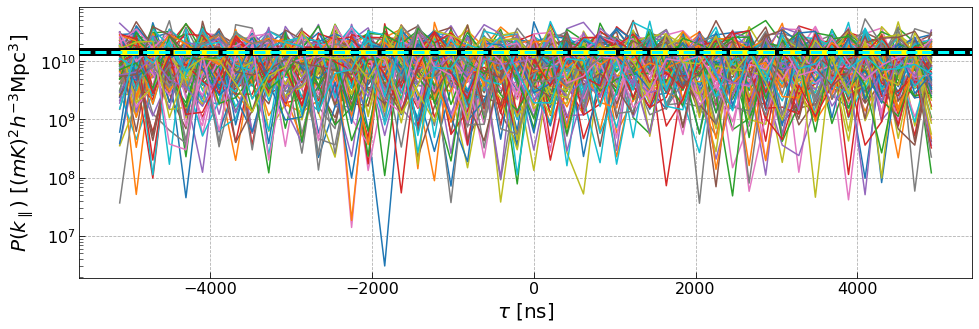

In [34]:
# plot it
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

hp.plot.delay_spectrum(uvp_avg.select(times=np.unique(uvp_avg.time_avg_array)[:100], inplace=False),
                       blpairs[:1], 0, 'xx', force_plot=True, ax=ax, component='real')
ax.tick_params(labelsize=16, direction='in', size=6)
ax.tick_params(which='minor', direction='in', size=4)
ax.axhline(avg_P_rms, color='k', lw=8, ls='-')
ax.plot(uvp_avg.dly_array*1e9, np.ones(uvp_avg.Ndlys) * avg_bs_err, color='yellow', lw=5, ls='--')
ax.axhline(np.median(avg_P_N[blpair_ints[0]]), color='cyan', lw=3, ls='--')
ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_ylabel(ax.get_ylabel(), fontsize=20)
ax.grid(ls='--')

__Figure 5__ | Averaged power spectra and respective $P_{\rm RMS}$ (black solid), $P_N$ (blue dashed), and $\sigma_{\rm BS}$ errorbar (yellow dashed), showing good agreement.

## 4. Summary

In this notebook we have:
* Generated mock noise visibilities for the HERA instrument, and computed their power spectra.
* We compared the unaveraged power spectra against analytic predictions of the noise power spectrum ($P_N$) and find the RMS of the power spectra to be consistent with $P_N$ to within <1%.
* We then incoherently average the power spectra along baselines, and compare the bootstrapped uncertainty on this average and $P_N$ for the averaged power spectra against their RMS (taken over the remaining time and delay axes). We also find good agreement between these estimates to within <1%.